In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy import optimize

from sklearn.model_selection import train_test_split

from scipy.io import savemat, loadmat

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)


with open('normal_pneumonia_train.npy', 'rb') as f:
    x_ray_features = np.load(f)
    x_ray_labels = np.load(f)

    
X_train, X_test, y_train, y_test = train_test_split(x_ray_features, x_ray_labels, 
                                                    test_size=2000, random_state=242)

classes = ['Normal', 'Pneumonia']

n = X_train.shape[0]
    
print(X_train.shape, y_train.shape, X_train.dtype)
print(X_test.shape, y_test.shape, X_test.dtype)
    
%matplotlib notebook

%load_ext autoreload
%autoreload 2

(11389, 1024) (11389,) float32
(2000, 1024) (2000,) float32


/home/ponir/.local/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


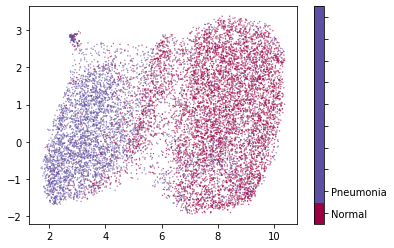

In [2]:
import umap

ump = umap.UMAP(n_neighbors=30,
        min_dist=0.1,
        n_components=2,
        random_state=150,
        metric= 'euclidean')

y_umap = ump.fit_transform(X_train)

plt.figure()
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=0.1, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

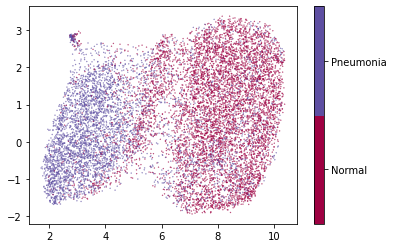

In [3]:
plt.figure()
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=0.1, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(len(classes)+1)-0.5)
cbar.set_ticks(np.arange(len(classes)))
cbar.set_ticklabels(classes)

In [4]:
dist = euclidean_distances(X_train, squared = False)


In [5]:
print(dist[0:4, 0:4])
print( np.sum((X_train[1,:] - (X_train[6,:]+X_train[5,:]))**2))

[[ 0.       19.11934  14.659819 22.707005]
 [19.11934   0.       17.86558  15.537004]
 [14.659819 17.86558   0.       20.728548]
 [22.707005 15.537004 20.728548  0.      ]]
1124.894


In [6]:
n_neighbors=30

sort_idx = np.argsort(dist,axis=1)

sort_idx = sort_idx[:,1:n_neighbors+1]
print(sort_idx.shape, sort_idx[:,1].shape)

rho = [ dist[i, sort_idx[i,0] ] for i in range(n)]
rho = np.array(rho)

print(rho[0:4])
print(rho.shape, rho.dtype)

(11389, 30) (11389,)
[11.349591  10.8193655 10.711745  11.013099 ]
(11389,) float32


In [7]:
import gc

print(gc.collect())


32519


In [9]:
def get_weight_function(dists, rho, sigma):
    d = dists - rho
    #print(d)
    d[d<0] = 0
    weight = np.exp(- d / sigma )
    return weight


def search_sigma(dists, rho, k, tol = 10**-5, n_iteration=200):
    sigma_min = 0
    sigma_max = 1000
    
    cur_sigma = 100
    
    logk = np.log2(k)
    #print(logk)
    
    for i in range(n_iteration):
        
        cur_sigma = (sigma_min+sigma_max)/2
        probs = get_weight_function(dists,rho,cur_sigma)
        weight = np.sum(probs)
        #print(weight)
        
        if np.abs(logk - weight) < tol:
            break
        
        if weight < logk:
            sigma_min = cur_sigma
        else:
            sigma_max = cur_sigma
        
    return cur_sigma, probs

In [10]:
sigmas = []

directed_graph = []
#'''
for i in range(n):
    if (i+1)%10000 == 0:
        print('Processed ', i+1, ' of ', n, ' samples.')
    sigma, weights = search_sigma(dists = dist[i,sort_idx[i,:]],rho = rho[i],k = n_neighbors)
    
    probs = np.zeros(n)
    probs[sort_idx[i,:]] = weights
    
    directed_graph.append(probs)

prob = np.array(directed_graph)
#'''  


Processed  10000  of  11389  samples.


In [11]:
import gc
gc.collect()


#'''
import numba 
from numba import prange
@numba.jit(nopython=True, parallel=True)
def symmetrization_step(prob):
    P = np.zeros((n,n),dtype=np.float32)

    for i in prange(n):
        #if i%1000 == 0:
        #    print('Completed ', i, ' of ', n)
        for j in prange(i,n):
            p = prob[i,j] + prob[j,i] - prob[i,j] * prob[j,i]
            P[i,j] = p
            P[j,i] = p
            
    return P


P = symmetrization_step(prob)
#'''
print(np.sum(P[0,:]==0))

    

print(P.shape)

11335
(11389, 11389)


In [12]:
print(P[0,P[0,:]>0])
np.sum(P[0,P[0,:]>0])

[1.         0.85778284 0.05695006 0.03965829 0.01782204 0.09503651
 0.08652832 0.07921318 0.06625591 0.33568257 0.27015468 0.20447086
 0.08825967 0.10350372 0.9063398  0.04852736 0.04878853 0.09571587
 0.17552947 0.20657295 0.0462854  0.33148184 0.2547935  0.11234387
 0.03442172 0.23135702 1.         0.11346007 0.34688133 0.15954214
 0.05137551 0.06669252 0.22218749 1.         0.08861858 0.06772478
 0.07688212 0.03932606 0.04532325 0.29005596 0.05729729 0.05905012
 0.21788226 0.29870442 0.12648489 0.09950981 0.18757188 0.21862833
 0.06846666 0.5136881  0.15846702 0.19247647 0.2261818  0.12980774]


11.915762

Hyperparameters a = 1.576943460405378 and b = 0.8950608781227859


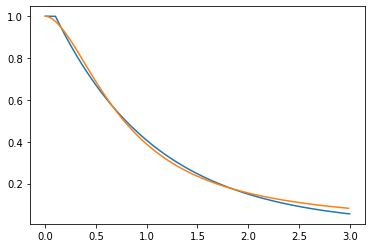

In [13]:
MIN_DIST = 0.1

x = np.linspace(0, 3, 300)
y = np.exp(- (x-MIN_DIST) * ( (x - MIN_DIST) >=0 ) )

dist_low_dim = lambda x, a, b: 1 / (1 + a*x**(2*b))

p , _ = optimize.curve_fit(dist_low_dim, x, y)

a = p[0]
b = p[1] 
print("Hyperparameters a = " + str(a) + " and b = " + str(b))

x_p = np.arange(0,3,0.01)
y_p = np.exp(- (x_p-MIN_DIST) * ( (x_p - MIN_DIST) >=0 ) )
y_p2 = 1 / (1 + a*x_p**(2*b))

plt.figure()
plt.plot(x,y, label='Target')
plt.plot(x_p,y_p2, label='Fitted')

In [14]:
import torch
from network_sig import network

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

model = network(channels=[X_train.shape[1],500,300,200,100,100,100,2]).to(device)

criterion_mse = torch.nn.MSELoss()

lr = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

In [15]:
Y = []
X_train32 = X_train.astype(np.float32)

print('Conversion Done')
X_torch = torch.as_tensor(X_train32, dtype=torch.float32).to(device)
Y_umap = torch.as_tensor(y_umap, dtype=torch.float32).to(device)

X_torch_test = torch.as_tensor(X_test, dtype=torch.float32).to(device)
print('Tensor Build Done')


Conversion Done
Tensor Build Done


completed  0  of  11389
completed  10000  of  11389
(11389, 2)


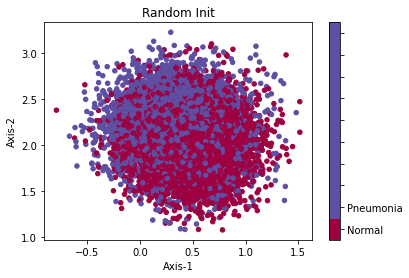

In [16]:
Y = []

with torch.no_grad():
    for i in range(n):
        if i%10000 == 0:
            print('completed ', i, ' of ', n)
            
        x_st = X_torch[i:i+1,:]
        #print(x_st.size())
        y_st = model(x_st).cpu().numpy().reshape(-1)
        #print(y_st.shape)
        Y.append(y_st)

Y = np.array(Y)
print(Y.shape)


plt.figure()#figsize=(20,15))
plt.scatter(Y[:,0], Y[:,1], c = y_train.astype(int), cmap = 'Spectral', s = 20)
plt.title("Random Init")
plt.xlabel("Axis-1") #, fontsize = 20); 
plt.ylabel("Axis-2") #, fontsize = 20)
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.show()
plt.show()

In [17]:
def criterion_pos_old(x,y,a,b):
    factor = 1 + a * torch.sum((x-y)**2, dim = 0) ** b
    y = torch.log(factor)
    
    return y

def criterion_neg_old(x,y,a,b):
    factor = a * torch.sum((x-y)**2) ** b
    y = - torch.log(0.0001+factor) + torch.log(1 + factor)
    
    return y

def phi(x,y,a,b):
    factor = 1 + a * torch.sum((x-y)**2+10**-8, dim=1) ** b
    y = 1/factor
    
    #for i in range(y.size()[0]):
    #    if np.isnan(y[i].cpu().detach().item()):
    #        print('Isnan in Pos Crit:', i, x[i], y[i])
    
    return y

def criterion_pos(x,y,p,a,b):
    prob = phi(x,y,a,b)
    y = -torch.log(prob)*p
    #for i in range(y.size()[0]):
    #    if np.isnan(y[i].cpu().detach().item()):
    #        print('Isnan in Pos Crit:', i)
    
    return torch.sum(y)

def criterion_neg(x,y,p,a,b):
    prob = phi(x,y,a,b)
    y = -torch.log(1-prob+0.000001)*(1-p)
    #for i in range(y.size()[0]):
    #    if np.isnan(y[i].cpu().detach().item()):
    #        print('Isnan in Neg Crit:', i)
    
    return torch.sum(y)
    

Y = model(X_torch[0:10,:])
Z = criterion_pos(Y[0:4,:],Y[4:8,:],1.0,1.0,1.0)
print(Y.size(), Z.size(), Z.item())

torch.Size([10, 2]) torch.Size([]) 0.8504899740219116


In [18]:
#from sklearn.manifold import SpectralEmbedding


#LEARNING_RATE = 1
epochs = 40

#xpp = xpp
#print(k)

print(n)

batch_size = 60
it_per_epoch = int(n/batch_size)
print('Iteration Per Epoch:', it_per_epoch)

CE_array = []
results = []
print("Running Gradient Descent: \n")

Nan_info = False

for epoch in range(epochs):
    
    for idx in range(n*5): #:
        choices_0 = np.random.choice(n, batch_size)
        k_ch = np.random.randint(low = 0, high = n_neighbors, size=batch_size)
        choices_1 = sort_idx[choices_0,k_ch]
        
        #print(choices_0.shape,choices_1.shape)
        
        Prob_sample = torch.as_tensor(P[choices_0,choices_1].reshape(-1), dtype=torch.float32).to(device)
        
        optimizer.zero_grad()
        
        loss = 0
        
        Y0 = model(X_torch[choices_0,:])
        Y1 = model(X_torch[choices_1,:])
        
        cr = criterion_pos(Y0, Y1, Prob_sample, a, b)
        loss = loss + cr
        #print(cr)
        
        
        if np.isnan(cr.detach().cpu().item()):
            Nan_info = True
            print(epoch,idx,cr)
            break
        
        CE_array.append(cr.cpu().detach().item())
        
        #gr_1 = get_grad_logphi(y[i,:], y[ij,:],a,b)
        #y[i,:] = y[i,:] + LEARNING_RATE * gr_1
        
        for j in range(5):
            k_ch = np.random.randint(low = 0, high = n, size=batch_size)
            #Y0 = model(X_torch[i:i+1,:])
            Y1 = model(X_torch[k_ch,:])
            Prob_sample = torch.as_tensor(P[choices_0,k_ch].reshape(-1), dtype=torch.float32).to(device)
            
            cr = criterion_neg(Y0, Y1, Prob_sample, a, b)
            loss = loss + cr
            #print('inside loop: ', cr)
            if np.isnan(cr.detach().cpu().item()):
                Nan_info = True
                print('inside loop: ', epoch, idx, j, cr)
                break
            
        if Nan_info == True:
            print('EVERYTHING IS NAN')
            break
        loss.backward()
        optimizer.step()
        
                
    #LEARNING_RATE = 1.0 - epoch / epochs
    if (epoch+1)%1 == 0:
        print('Completed ', epoch , ' of ', epochs)
        torch.save(model.state_dict(), 'nets_pneumonia_UMAP_CE/epoch'+str(epoch)+'.pth')
        
        Y = []
        Y_test = []
        with torch.no_grad():
            for i in range(n):
                x_st = X_torch[i:i+1,:]
                y_st = model(x_st).cpu().numpy().reshape(-1)
                #print(y_st.shape)
                Y.append(y_st)
            

            
            for i in range(X_test.shape[0]):
                x_st = X_torch_test[i:i+1,:]
                #print(x_st.size())
                y_st = model(x_st).cpu().numpy().reshape(-1)
                #print(y_st.shape)
                Y_test.append(y_st)
        
        Y_test = np.array(Y_test)
        Y = np.array(Y)
        
        neigh.fit(Y, y_train) 
        y_nene_out = neigh.predict(Y_test)
        
        result = 1-np.mean(y_nene_out==y_test)
        
        results.append(result)
        
        d = {}
        d['Y'] = Y
        d['Y_test'] = Y_test
        savemat('nets_pneumonia_UMAP_CE/test_data'+str(epoch)+'.mat', d)
        
        print('Error :', result)
        
    if (epoch+1)/5 == 0:
        lr = lr/10
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

11389
Iteration Per Epoch: 189
Running Gradient Descent: 

Completed  0  of  40
Error : 0.25149999999999995
Completed  1  of  40
Error : 0.22899999999999998
Completed  2  of  40
Error : 0.23550000000000004
Completed  3  of  40
Error : 0.25049999999999994
Completed  4  of  40
Error : 0.22699999999999998
Completed  5  of  40
Error : 0.23650000000000004
Completed  6  of  40
Error : 0.22350000000000003
Completed  7  of  40
Error : 0.23150000000000004
Completed  8  of  40
Error : 0.22750000000000004
Completed  9  of  40
Error : 0.22650000000000003
Completed  10  of  40
Error : 0.23150000000000004
Completed  11  of  40
Error : 0.22750000000000004
Completed  12  of  40
Error : 0.23950000000000005
Completed  13  of  40
Error : 0.23250000000000004
Completed  14  of  40
Error : 0.24350000000000005
Completed  15  of  40
Error : 0.23150000000000004
Completed  16  of  40
Error : 0.22650000000000003
Completed  17  of  40
Error : 0.21950000000000003
Completed  18  of  40
Error : 0.23950000000000005
C

completed  0  of  11389
completed  10000  of  11389
[[  3.5958908   -2.739726  ]
 [  0.13058251  -9.446089  ]
 [  2.482317    -3.6350884 ]
 ...
 [  1.5657272  -18.47694   ]
 [ -1.7257167   -5.0033765 ]
 [  8.674993   -18.240393  ]]


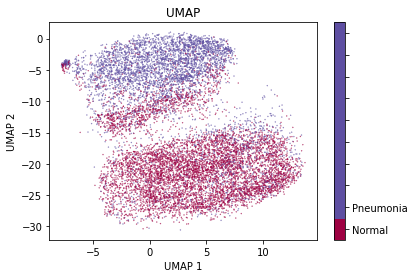

In [20]:
Y = []

with torch.no_grad():
    for i in range(n):
        if i%10000 == 0:
            print('completed ', i, ' of ', n)
            
        x_st = X_torch[i:i+1,:]
        #print(x_st.size())
        y_st = model(x_st).cpu().numpy().reshape(-1)
        #print(y_st.shape)
        Y.append(y_st)

Y = np.array(Y)
print(Y)

plt.figure()#figsize=(20,15))
plt.scatter(Y[:,0], Y[:,1], c = y_train.astype(int), cmap = 'Spectral', s = 0.1)
plt.title("UMAP")
plt.xlabel("UMAP 1") #, fontsize = 20); 
plt.ylabel("UMAP 2") #, fontsize = 20)
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.show()
plt.show()